In [28]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
en_words = set(nltk.corpus.words.words('en'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df_emb = pd.read_csv('EMB_all.csv',index_col = 0)
df_emb = df_emb.reset_index().drop('index',axis = 1)
df_emb['date'] = pd.to_datetime(df_emb['date'])
df_emb.dtypes

date        datetime64[ns]
userName            object
review              object
rating               int64
dtype: object

In [40]:
new_word = ['love','fun','game','cute','like','addict','supper','get','play','cant',
           'wa','dont','use','even','really','wont','would','one','keep','work',
           'ha','want','back','please','give','need','make','still','every','since',
           'doesnt','lose','day','good','let','go','way','open','also','able',
            'take','getting','much','great','could','start','didnt','spend','lot','last',
           'thing','many','tried','say','u','already','know','text','entertain','enjoy',
           'cool','veri','blitz','best','super','year','new','thank','bore','nice',
            'phone','think','stop','far','better','fan','mani','jam','pass','always',
            'hour','killer','recommend','got','everyday']

In [41]:
stop_words.update(new_word)

### Preprocess

replace '\n'; lowercase(); remove punctuation/number/link/non ascii words; tokens(stem/lemmetize/n_grams)

In [42]:
def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # remove '\n'
    text = text.replace('\n','')
    # lowercase text
    text = text.lower()
    # remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    # remove number
    text = re.sub(r'[0-9]+', '', text)
    # remove links
    text = re.sub(r'http\S+', '', text) 
    # remove non ascii words
    text = re.sub(r'[^\x00-\x7F]+','', text)
    # stemmer 
    text = ' '.join([stemmer.stem(w) for w in text.split()])
    # remove stop words
    text = ' '.join(word for word in text.split(' ') if word not in stop_words) 
    # remove non-english word
    text = ' '.join(word for word in text.split() if word in en_words) 
    return text

In [44]:
df_emb.review = df_emb.review.apply(clean_text)

In [45]:
# Run TF IDF Vectorizer on the text data
vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=10, max_df = 150000,
                             norm='l2', ngram_range = (1,4), stop_words='english')
X_train_vc = vectorizer.fit_transform(df_emb["review"])
df_tfidf = pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names())

In [46]:
df_emb.shape, df_tfidf.shape

((170699, 4), (170699, 7535))

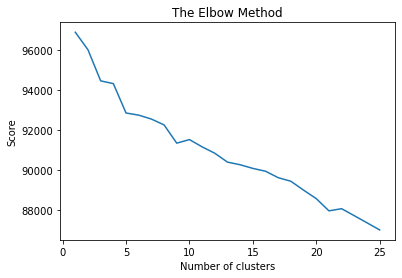

In [48]:
k_clusters = 25

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(X_train_vc)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

In [49]:
k_clusters = 21

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(max_iter=600, n_clusters=21, random_state=0, tol=1e-06)

In [50]:
clusters = model.predict(X_train_vc)

/var/folders/7c/8ptk959x0m533j_8q9d72vn00000gn/T/ipykernel_13429/167774861.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 2))


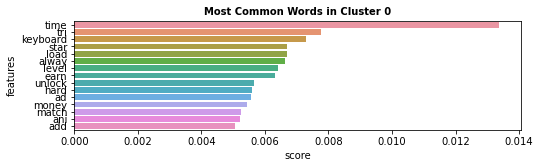

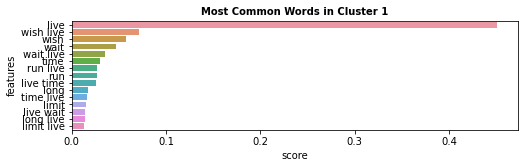

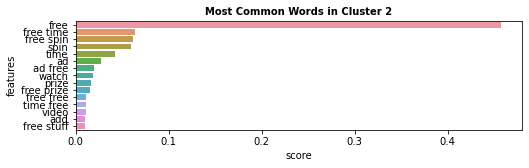

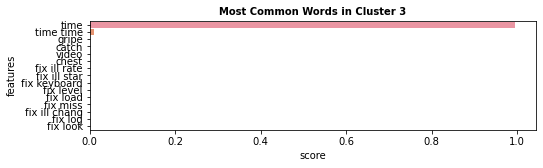

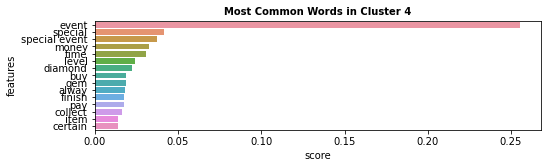

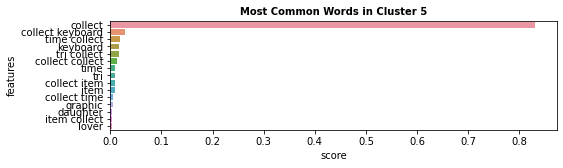

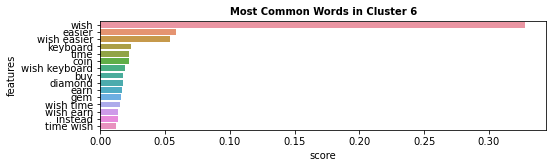

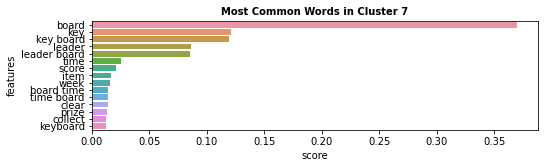

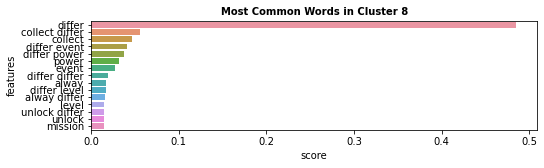

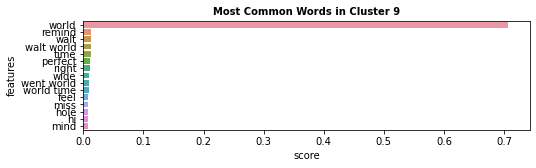

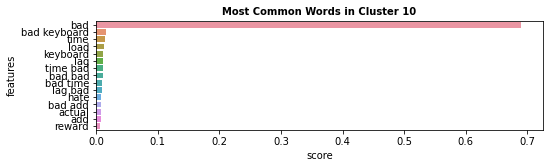

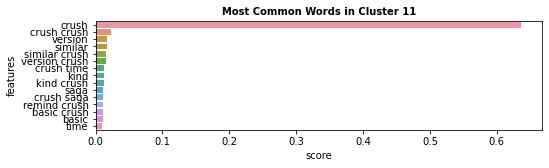

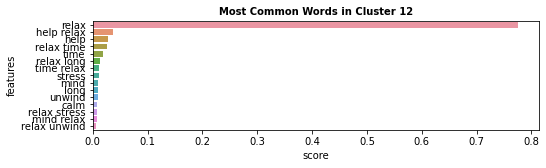

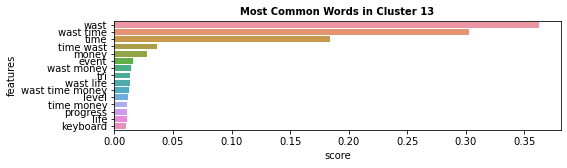

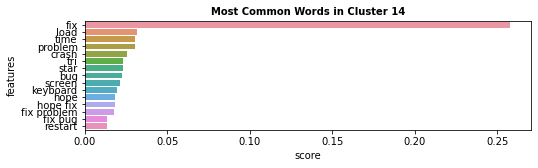

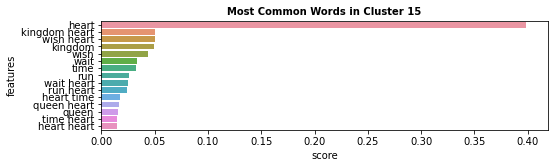

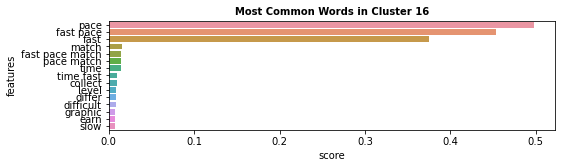

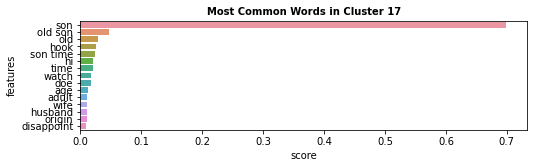

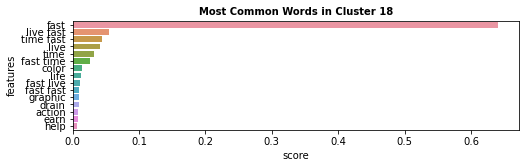

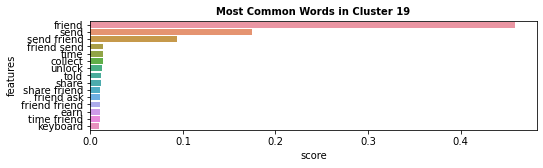

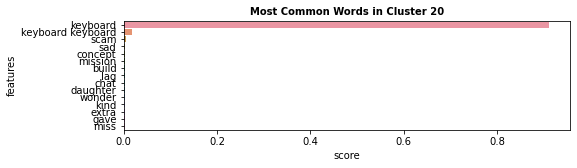

In [51]:
# after 3-rd changing stopword
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), clusters, 15)
plotWords(dfs, 15)

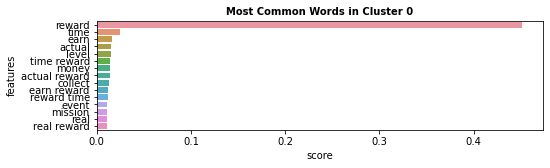

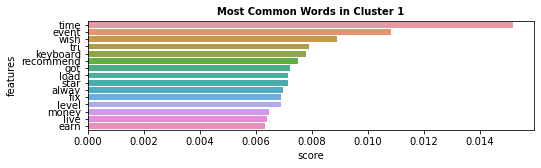

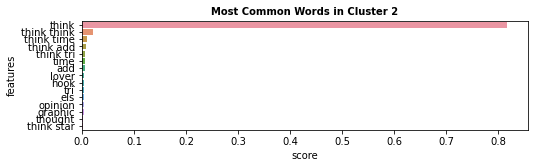

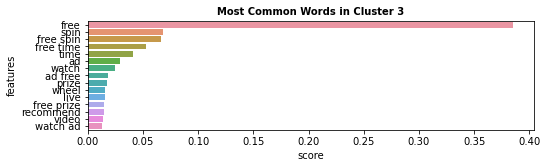

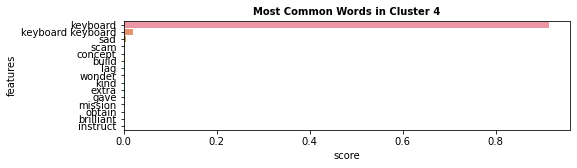

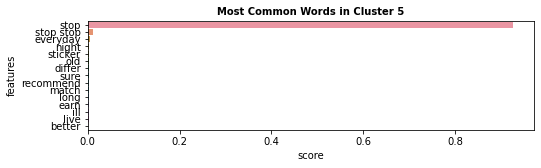

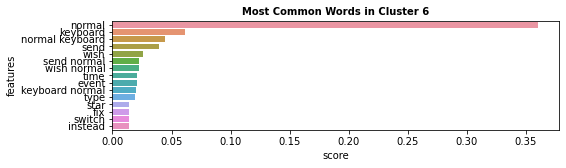

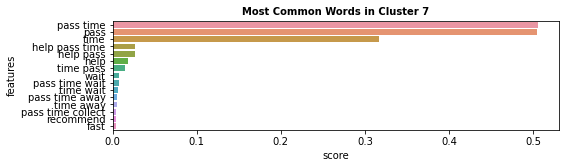

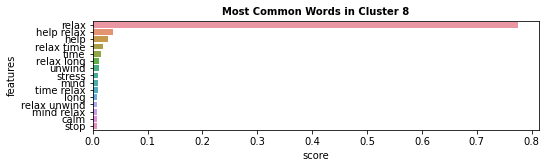

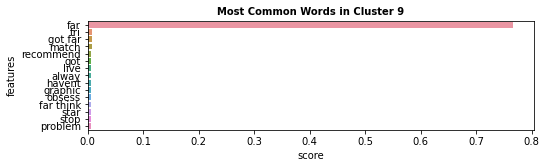

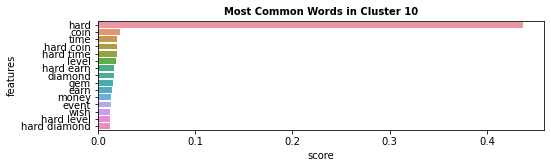

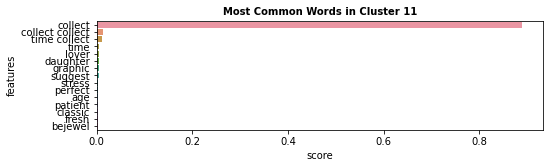

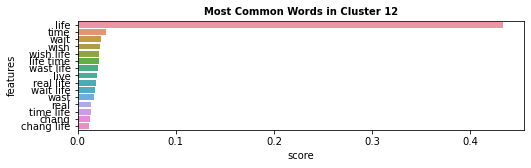

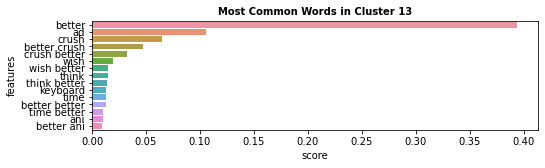

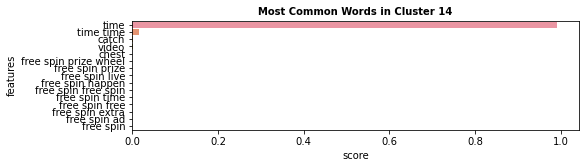

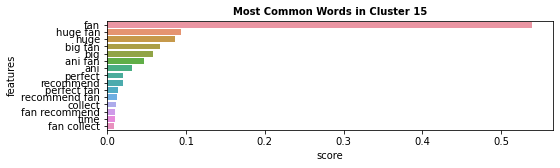

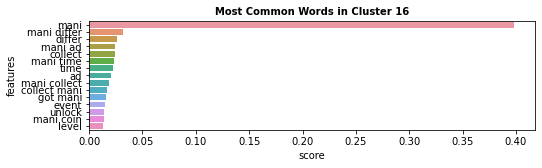

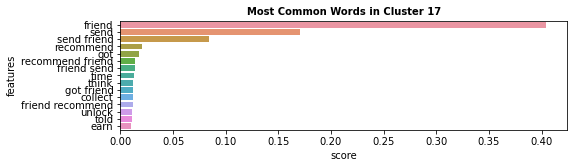

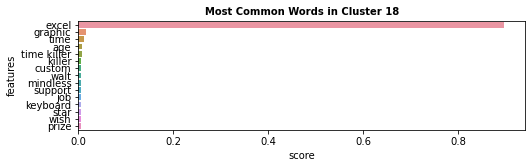

In [24]:
# after changing stopword
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), clusters, 15)
plotWords(dfs, 15)

### New cluster: reward, hard coin, hard time
### Invalid: 2-think, 5-stop, 9-far, 13- better, 15- fan, 16- mani

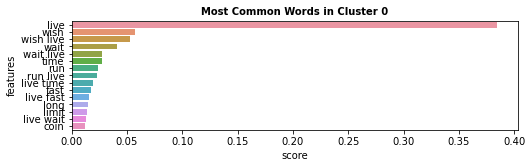

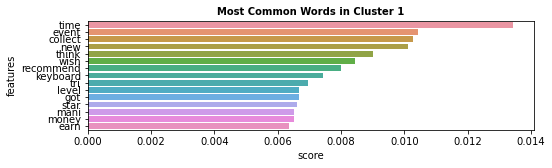

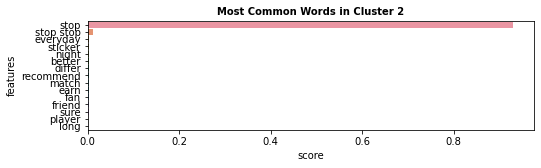

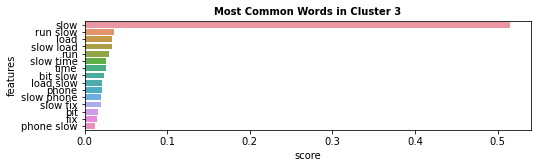

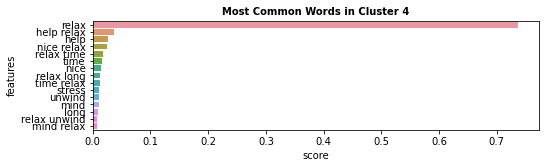

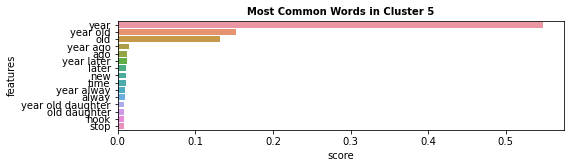

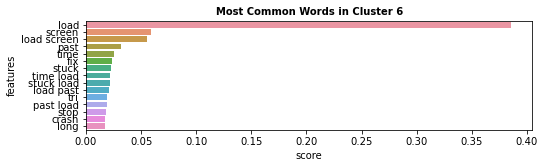

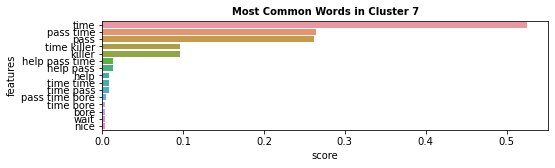

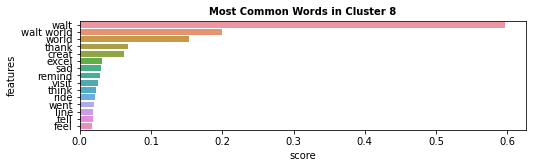

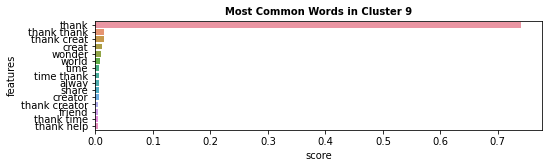

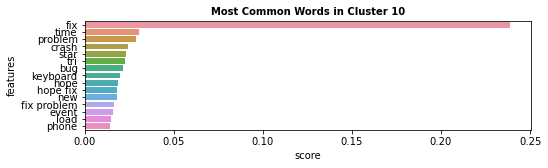

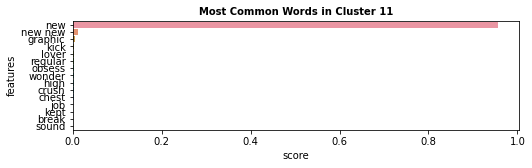

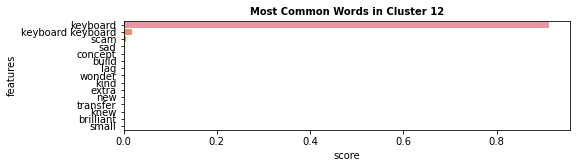

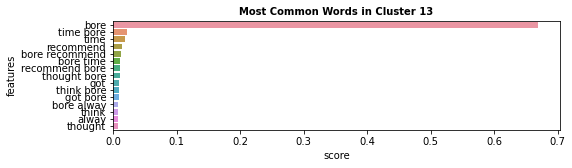

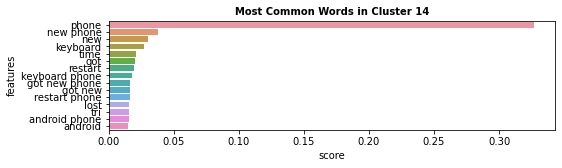

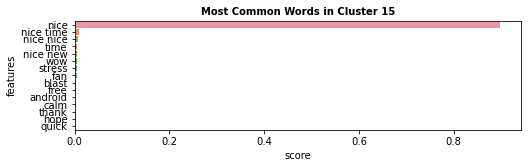

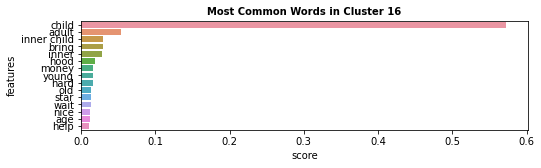

In [13]:
# change before
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), clusters, 15)
plotWords(dfs, 15)

### valid cluster name: live, stop, run slow, relax, stop, load/stuck, time killer, walt, fix, child, keyboard
### invalid: cluster 1 messy, cluster 5 (year), cluster 9 ('thank'), cluster 11('new'), cluster 13 ('bore'), cluster 14 ('phone'), cluster 15 ('nice'), 

In [54]:
df_emb_1 = df_emb.loc[df_emb['rating']== 1].reset_index().drop('index',axis = 1)
df_emb_2 = df_emb.loc[df_emb['rating']== 2].reset_index().drop('index',axis = 1)
df_emb_3 = df_emb.loc[df_emb['rating']== 3].reset_index().drop('index',axis = 1)
df_emb_4 = df_emb.loc[df_emb['rating']== 4].reset_index().drop('index',axis = 1)
df_emb_5 = df_emb.loc[df_emb['rating']== 5].reset_index().drop('index',axis = 1)

In [55]:
print('The shape of score_1 player data is ',df_emb_1.shape)
print('The shape of score_2 player data is ',df_emb_2.shape)
print('The shape of score_3 player data is ',df_emb_3.shape)
print('The shape of score_4 player data is ',df_emb_4.shape)
print('The shape of score_5 player data is ',df_emb_5.shape)

The shape of score_1 player data is  (12165, 4)
The shape of score_2 player data is  (5910, 4)
The shape of score_3 player data is  (10848, 4)
The shape of score_4 player data is  (23329, 4)
The shape of score_5 player data is  (118447, 4)


In [ ]:
vectorizer_4 = TfidfVectorizer(sublinear_tf= True, min_df=11, max_df = 9000,
                             norm='l2', ngram_range = (1,4), stop_words='english')
X_train_vc_3 = vectorizer_1.fit_transform(df_emb_3["review"])
plot_cluster(X_train_vc_3, k_clusters = 20)

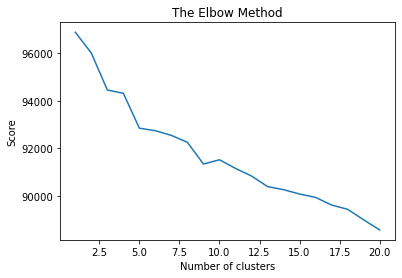

In [70]:
vectorizer_3 = TfidfVectorizer(sublinear_tf= True, min_df=11, max_df = 9000,
                             norm='l2', ngram_range = (1,4), stop_words='english')
X_train_vc_3 = vectorizer_1.fit_transform(df_emb_3["review"])
plot_cluster(X_train_vc_3, k_clusters = 20)

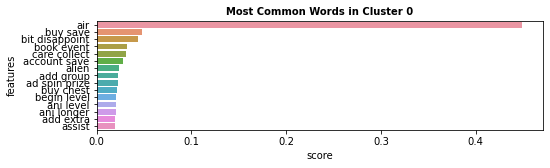

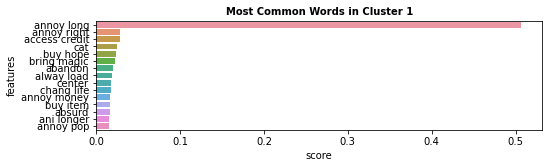

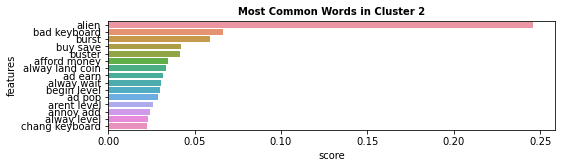

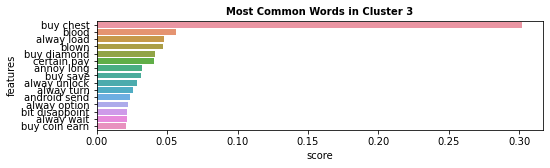

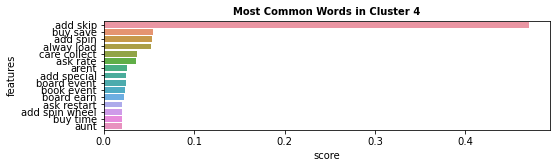

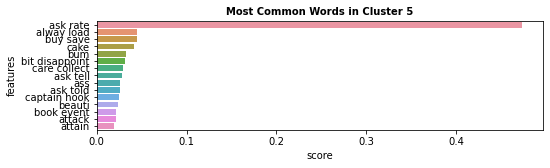

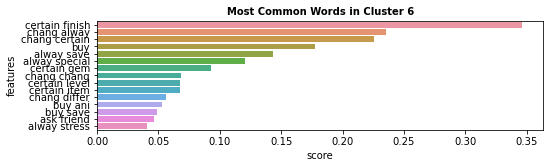

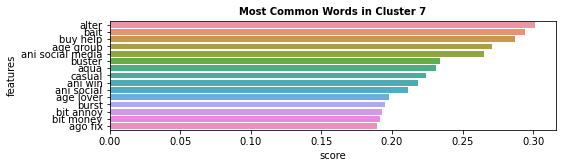

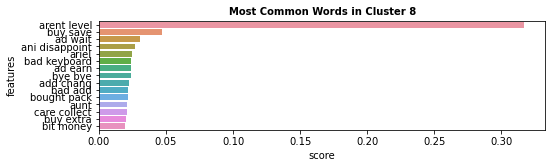

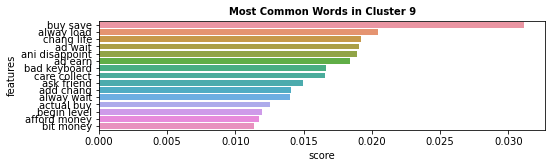

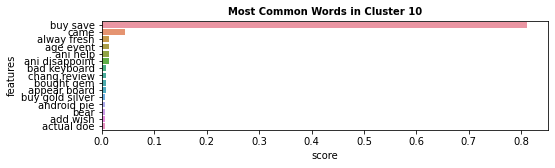

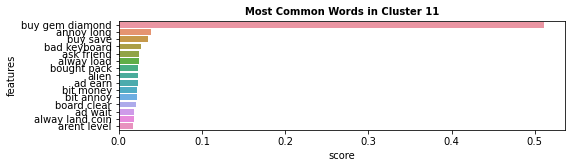

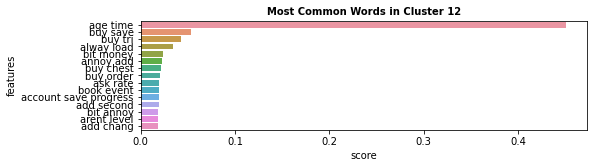

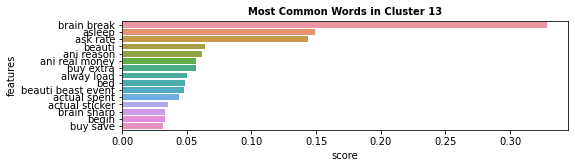

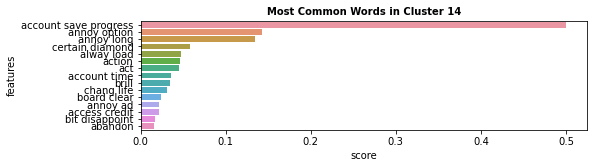

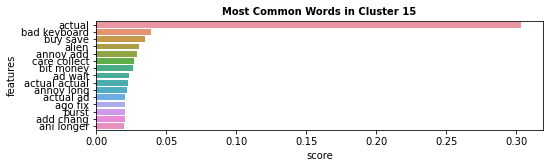

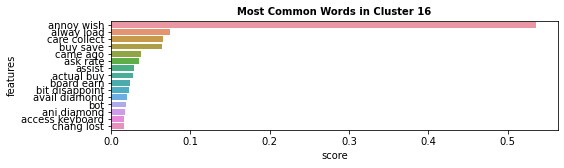

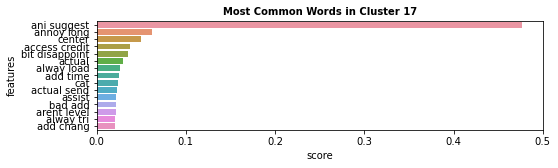

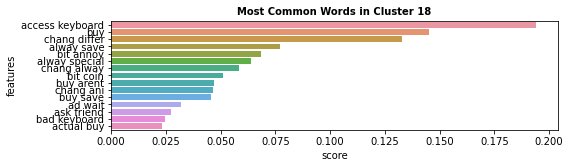

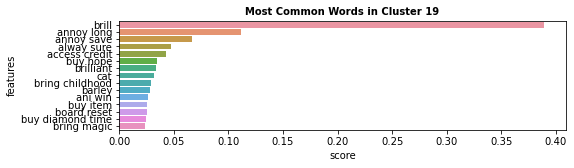

In [71]:
cluster_name(k_clusters = 20, X_train_vc = X_train_vc_3)

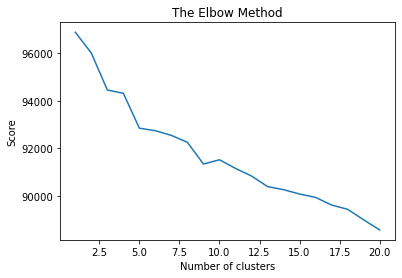

In [68]:
vectorizer_2 = TfidfVectorizer(sublinear_tf= True, min_df=5, max_df = 5000,
                             norm='l2', ngram_range = (1,4), stop_words='english')
X_train_vc_2 = vectorizer_1.fit_transform(df_emb_2["review"])
plot_cluster(X_train_vc_2, k_clusters = 20)

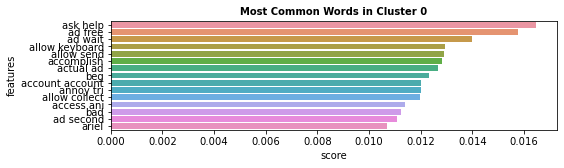

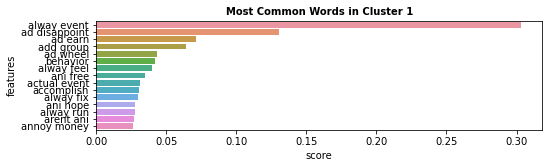

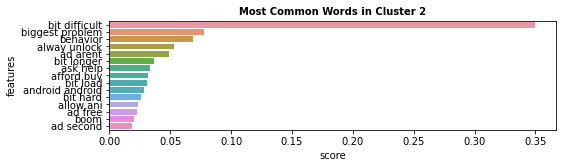

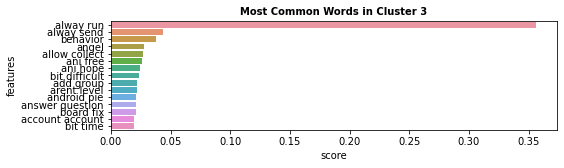

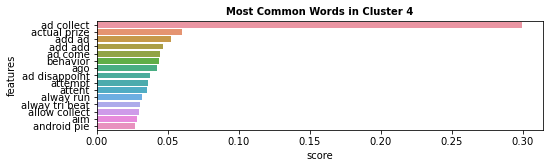

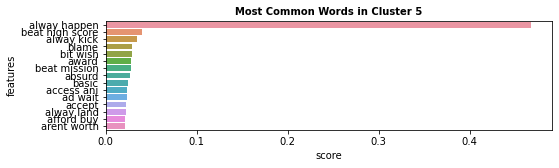

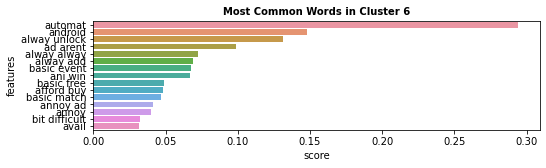

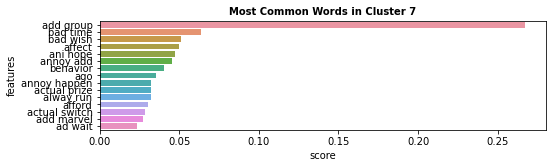

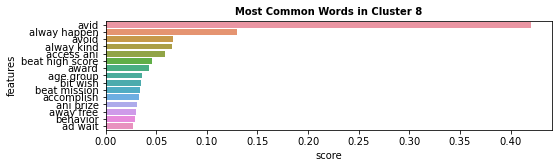

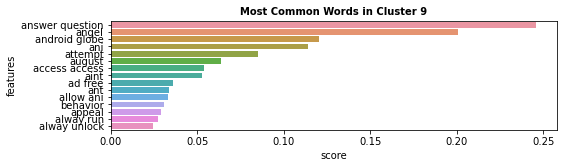

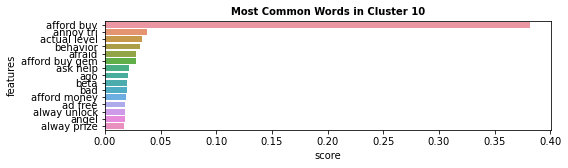

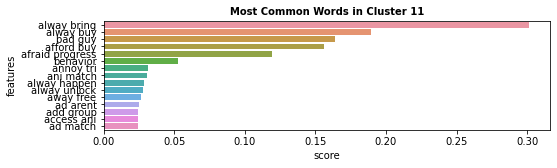

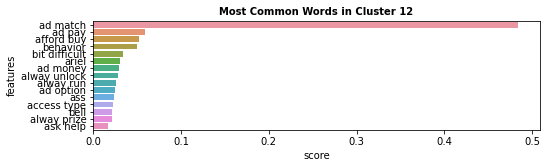

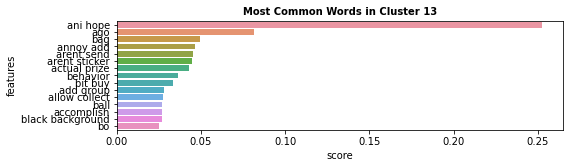

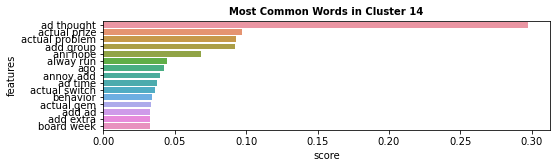

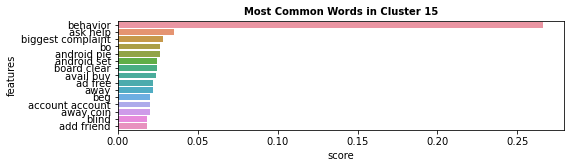

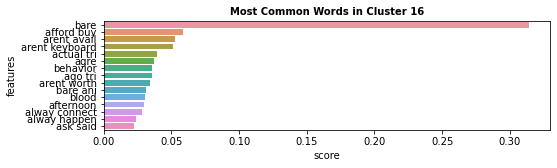

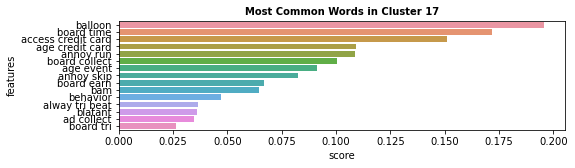

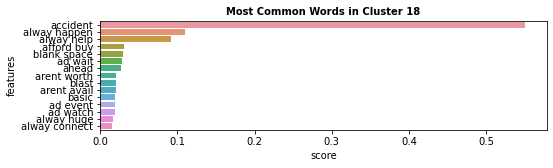

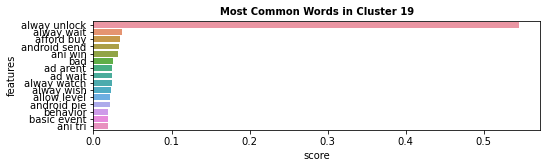

In [69]:
cluster_name(k_clusters = 20, X_train_vc = X_train_vc_2)

In [56]:
vectorizer_1 = TfidfVectorizer(sublinear_tf= True, min_df=13, max_df = 10000,
                             norm='l2', ngram_range = (1,4), stop_words='english')
X_train_vc_1 = vectorizer_1.fit_transform(df_emb_1["review"])
df_tfidf_1 = pd.DataFrame(X_train_vc_1.toarray(), columns=vectorizer_1.get_feature_names())

In [61]:
def plot_cluster(df, k_clusters = 20):   
    score = []
    for i in range(1,k_clusters + 1):
        kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
        kmeans.fit(X_train_vc)
        score.append(kmeans.inertia_)
    plt.plot(range(1,k_clusters + 1 ),score)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.show()

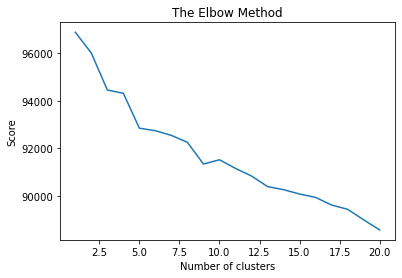

In [62]:
plot_cluster(X_train_vc_1, k_clusters = 20)

In [65]:
def cluster_name(k_clusters,X_train_vc):
    model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
    model.fit(X_train_vc)
    clusters = model.predict(X_train_vc)
    dfs = get_top_features_cluster(X_train_vc.toarray(), clusters, 15)
    plotWords(dfs, 15)

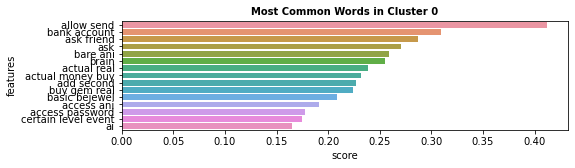

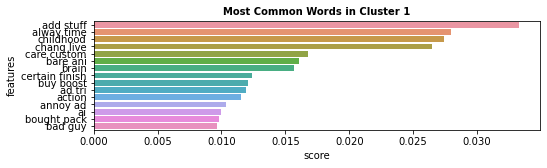

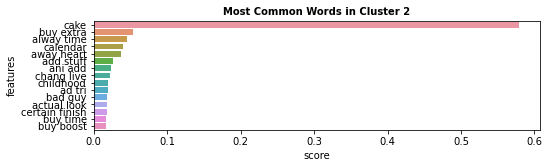

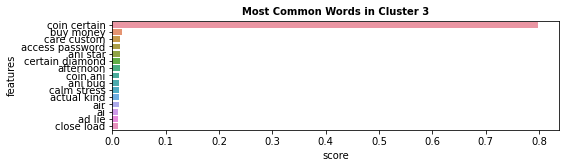

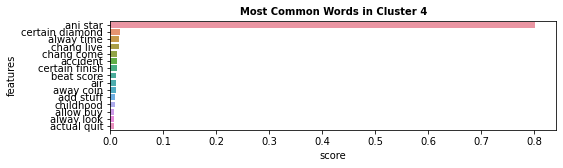

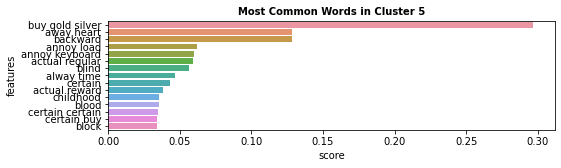

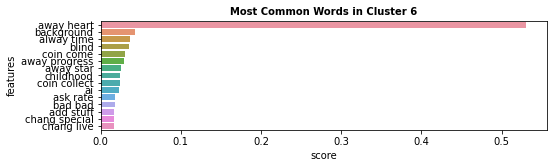

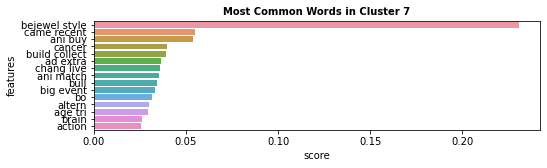

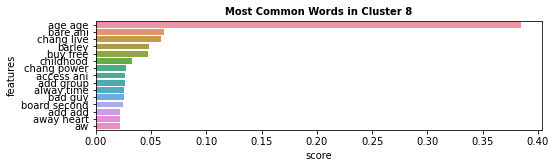

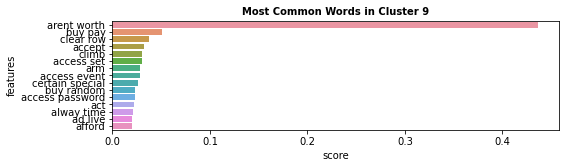

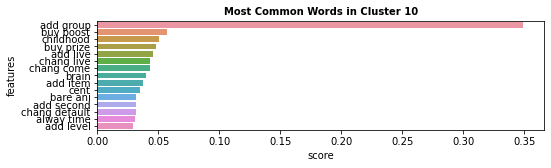

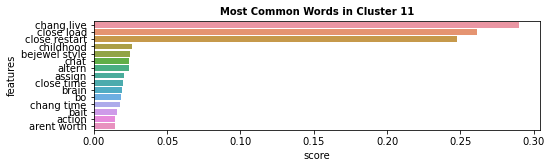

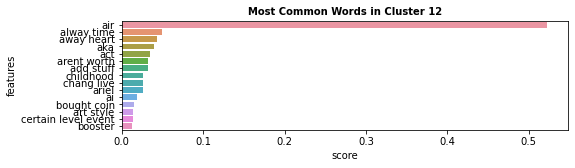

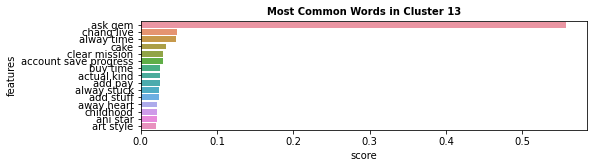

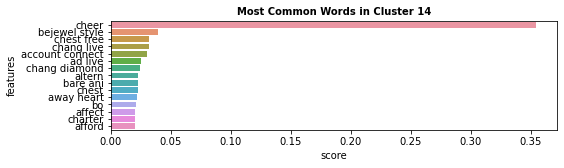

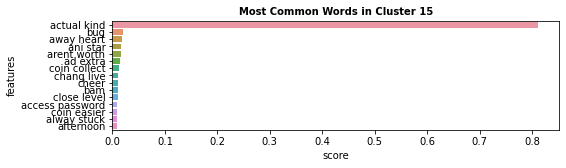

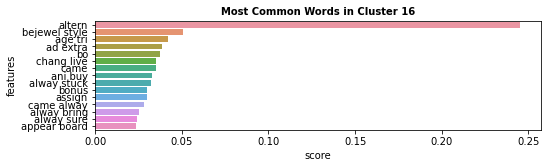

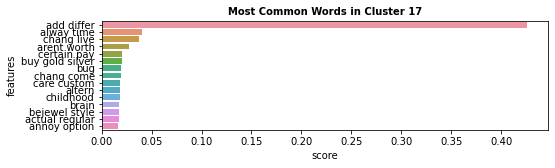

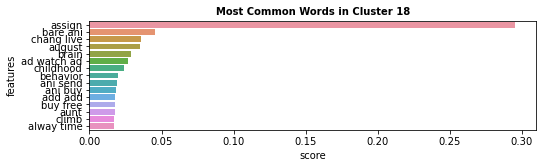

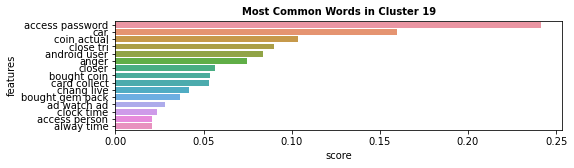

In [67]:
cluster_name(k_clusters = 20, X_train_vc = X_train_vc_1)

score_1 cluster(monetization): coin certain(3), buy gold/silver(5), arent worth(9), buy boost(10), ask gem(13)